In [409]:
import numpy as np
import pandas as pd
import h5py
import json
import os
import matplotlib.pyplot as plt
from itertools import compress
import calfews_src
# from read_hdf5_output import get_results_sensitivity_number
from calfews_src import *
from calfews_src.visualizer import Visualizer
from calfews_src.util import *
import seaborn as sns
importlib.reload(make_financial_data_km)
from make_financial_data_km import analyze_correlation_between_pumping_and_revenue
from make_financial_data_km import analyze_correlation_between_pumping_and_revenue_historical
from make_financial_data_km import analyze_correlation_between_total_revenue_and_pumping

import importlib
import make_financial_data_km
from calfews_src.strategy_compare import plot_water_purchase_costs
importlib.reload(make_financial_data_km)
importlib.reload(calfews_src.strategy_compare)


<module 'calfews_src.strategy_compare' from 'c:\\Users\\danli\\OneDrive - University of North Carolina at Chapel Hill\\github\\CALFEWS_waterFutures\\calfews_src\\strategy_compare.py'>

In [5]:
# districts = [
#     'kerndelta', 'wheeler', 'westkern', 'belridge', 
#     'berrenda', 'semitropic', 'rosedale', 'buenavista', 
#     'cawelo', 'henrymiller', 'losthills'
# ]

# years_to_include = 3

# results = {}
# for district in districts:
#     x, y = analyze_correlation_between_pumping_and_revenue(district, years_to_include)
#     # Store or print the results as needed
#     results[district] = (x, y)
#     print(f"District: {district}, X: {x}, Y: {y}")

In [ ]:
# districts = [
#     'kerndelta', 'wheeler', 'westkern', 'belridge', 
#     'berrenda', 'semitropic', 'rosedale', 'buenavista', 
#     'cawelo', 'henrymiller', 'losthills'
# ]

# data_frames = []
# for district in districts:
#     file_name = f"plots/pumping_vs_revenue_{district}_3yr.csv"
#     df = pd.read_csv(file_name, usecols=['Year', 'Simulation', 'Total Pumping', 'Annual Revenue'])
#     df.rename(columns={'Annual Revenue': f'Annual Revenue {district}'}, inplace=True)
#     data_frames.append(df)

# # Merge all dataframes on 'Year', 'Simulation', 'Total Pumping'
# combined_df = data_frames[0]
# for df in data_frames[1:]:
#     combined_df = combined_df.merge(df, on=['Year', 'Simulation', 'Total Pumping'], how='outer')

# # Sum up the 'Annual Revenue' columns
# revenue_columns = [f'Annual Revenue {district}' for district in districts]
# combined_df['Total Annual Revenue'] = combined_df[revenue_columns].sum(axis=1)

# combined_df.to_csv("plots/pumping_vs_revenue_KCWA_3yr.csv", index=False, columns=['Year', 'Simulation', 'Total Pumping', 'Total Annual Revenue'])

In [453]:
import os
import glob

folder_path = "results/30_year"  # e.g., "plots" or "../results"

# Find all CSV files recursively
csv_files = glob.glob(os.path.join(folder_path, "**", "*.csv"), recursive=True)

for file_path in csv_files:
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except Exception as e:
        print(f"Failed to delete {file_path}: {e}")

Deleted: results/30_year\2024_13\calfews_src-data-synth_2024_13_0.csv


# Basis risk examination

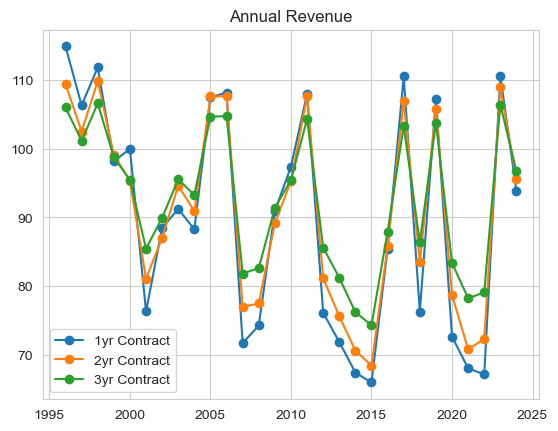

In [448]:
revenue_3y = pd.read_csv('plots/pumping_vs_revenue_KCWA_3yr.csv')
# revenue_3y = pd.read_csv('plots/pumping_vs_revenue_KCWA_30years_longleaf.csv')
revenue_3y['GroupNumber'] = None
counters = {}

for index, row in revenue_3y.iterrows():
    year = row['Year']
    simulation = row['Simulation']
    key = (year, simulation)

    if key not in counters:
        counters[key] = 1
    else:
        counters[key] += 1

    revenue_3y.at[index, 'GroupNumber'] = counters[key]

group_sorted = revenue_3y.sort_values(by=['Year', 'Simulation', 'GroupNumber'])

average_revenue_3y = revenue_3y.groupby(['Year','GroupNumber'])['Total Annual Revenue'].mean()
average_revenue_3y = average_revenue_3y.reset_index()
filtered_1y = average_revenue_3y[average_revenue_3y['GroupNumber'] == 1]
filtered_2y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2)]
filtered_2y = filtered_2y.groupby(['Year']).mean().reset_index()
filtered_3y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2) | (average_revenue_3y['GroupNumber'] == 3)]
filtered_3y = filtered_3y.groupby(['Year']).mean().reset_index()
plt.plot(filtered_1y['Year'], filtered_1y['Total Annual Revenue'], label = '1yr Contract', marker='o')
plt.plot(filtered_2y['Year'], filtered_2y['Total Annual Revenue'], label = '2yr Contract', marker='o')
plt.plot(filtered_3y['Year'], filtered_3y['Total Annual Revenue'], label = '3yr Contract', marker='o')
plt.legend()
plt.title('Annual Revenue')
plt.show()

In [ ]:
# group_sorted.to_csv('plots/pumping_vs_revenue_KCWA_3yr.csv', index=False, columns=['Year', 'Simulation', 'Total Pumping', 'Total Annual Revenue', 'GroupNumber'])
# group_sorted.to_csv('plots/pumping_vs_revenue_KCWA_30years_longleaf.csv', index=False, columns=['Year', 'Simulation', 'Total Pumping', 'Total Annual Revenue', 'GroupNumber'])


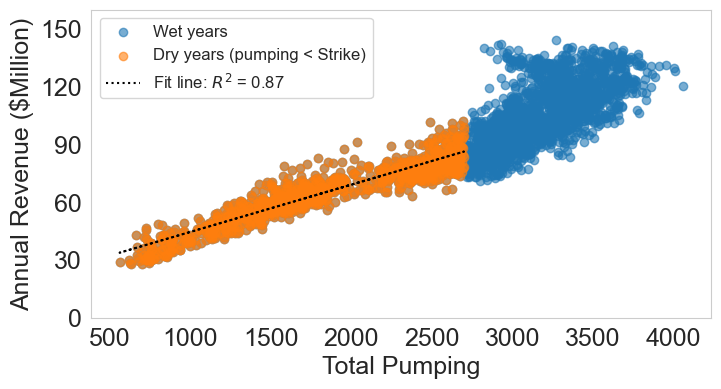

In [289]:
#######################basis risk for 2-year synthetic data#######################
###################### kern county water agency ##################################

fig, ax = plt.subplots(figsize=(8, 4))
read_file = 'plots/pumping_vs_revenue_KCWA_3yr.csv'
read_file= pd.read_csv(read_file, index_col=0, parse_dates=True)
revenue_3y['GroupNumber'] = None
counters = {}

for index, row in revenue_3y.iterrows():
    year = row['Year']
    simulation = row['Simulation']
    key = (year, simulation)
    if key not in counters:
        counters[key] = 1
    else:
        counters[key] += 1

    revenue_3y.at[index, 'GroupNumber'] = counters[key]

group_sorted = revenue_3y.sort_values(by=['Year', 'Simulation', 'GroupNumber'])

group_sorted_2yr = group_sorted[group_sorted['GroupNumber'] == 1]
y = group_sorted_2yr['Total Annual Revenue']
x = group_sorted_2yr['Total Pumping']

x_threshold = 2700

filtered_data = group_sorted_2yr[group_sorted_2yr['Total Pumping'] < x_threshold]
x_filtered = filtered_data['Total Pumping']
y_filtered = filtered_data['Total Annual Revenue']

ax.scatter(x, y, alpha=0.6, label='Wet years ')
ax.scatter(x_filtered, y_filtered, alpha=0.6, label='Dry years (pumping < Strike)')

slope_kcwa, intercept = np.polyfit(x_filtered, y_filtered, 1)
line = slope_kcwa * x_filtered + intercept  # Line equation for filtered data
corr_coef = np.corrcoef(x_filtered, y_filtered)[0, 1]
r_squared = corr_coef ** 2
plt.plot(x_filtered, line, 'black', linestyle=':', label=f'Fit line: $R^2$ = {r_squared:.2f}')


corr_coef = np.corrcoef(x_filtered, y_filtered)[0, 1]

ax.set_xlabel("Total Pumping",  fontsize=18)
ax.set_ylabel("Annual Revenue ($Million)",  fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid(False)
ax.legend(fontsize=12)
ax.set_ylim(0, 160)
plt.yticks(np.arange(0,160,30))

# ax.set_xlim(500, 4400)
# plt.savefig('plots/pumping_vs_revenue_KCWA_2yr.png')
plt.show()


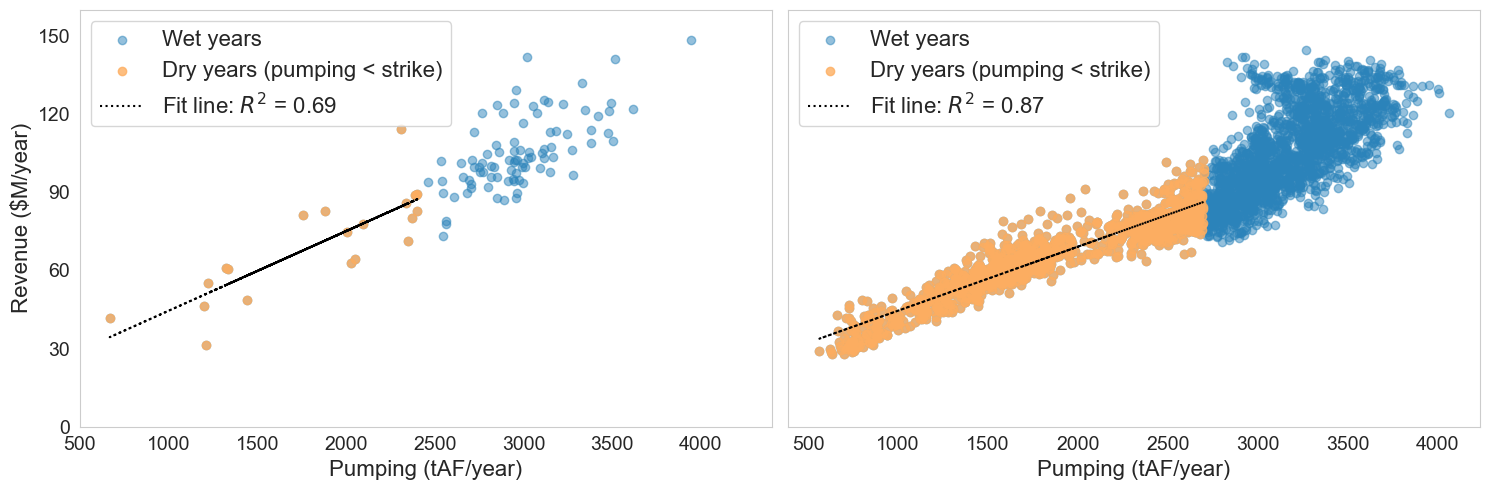

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------- First Plot: 110-year Historical Data ------------
revenue_file = 'plots/pumping_vs_revenue_KCWA_110yr.csv'
Yearly_revenue = pd.read_csv(revenue_file)

x_threshold = 2704 * 0.9
filtered_data_110 = Yearly_revenue[Yearly_revenue['Total Pumping'] < x_threshold]
x_110 = filtered_data_110['Total Pumping']
y_110 = filtered_data_110['Annual Revenue']

slope_110, intercept_110 = np.polyfit(x_110, y_110, 1)
line_110 = slope_110 * x_110 + intercept_110
r_squared_110 = np.corrcoef(x_110, y_110)[0, 1] ** 2

# ----------- Second Plot: 2-year Synthetic Data ------------
read_file = 'plots/pumping_vs_revenue_KCWA_3yr.csv'
revenue_3y = pd.read_csv(read_file, index_col=0, parse_dates=True)

revenue_3y['GroupNumber'] = revenue_3y.groupby(['Year', 'Simulation']).cumcount() + 1
group_sorted_2yr = revenue_3y[revenue_3y['GroupNumber'] == 1]

x_2yr = group_sorted_2yr['Total Pumping']
y_2yr = group_sorted_2yr['Total Annual Revenue']
x_threshold_2yr = 2700

filtered_2yr = group_sorted_2yr[x_2yr < x_threshold_2yr]
x_2yr_filt = filtered_2yr['Total Pumping']
y_2yr_filt = filtered_2yr['Total Annual Revenue']

slope_2yr, intercept_2yr = np.polyfit(x_2yr_filt, y_2yr_filt, 1)
line_2yr = slope_2yr * x_2yr_filt + intercept_2yr
r_squared_2yr = np.corrcoef(x_2yr_filt, y_2yr_filt)[0, 1] ** 2

# ----------- Combined Plot ------------
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# --- Left subplot: 110-year ---
axs[0].scatter(Yearly_revenue['Total Pumping'], Yearly_revenue['Annual Revenue'], color = '#2b83ba', alpha=0.5, label='Wet years')
axs[0].scatter(x_110, y_110, color= '#fdae61',  alpha=0.8, label='Dry years (pumping < strike)')
axs[0].plot(x_110, line_110, 'black', linestyle=':', label=f'Fit line: $R^2$ = {r_squared_110:.2f}')
axs[0].set_xlabel("Pumping (tAF/year)", fontsize=16)
axs[0].set_ylabel("Revenue ($M/year)", fontsize=16)
axs[0].set_xlim(500, 4400)
axs[0].set_ylim(50, 160)
axs[0].set_yticks(np.arange(0, 160, 30))
axs[0].tick_params(axis='both', labelsize=14)
axs[0].legend(fontsize=16)
axs[0].grid(False)

# --- Right subplot: 2-year synthetic ---
axs[1].scatter(x_2yr, y_2yr,color = '#2b83ba',  alpha=0.5, label='Wet years')
axs[1].scatter(x_2yr_filt, y_2yr_filt, color= '#fdae61', alpha=0.8, label='Dry years (pumping < strike)')
axs[1].plot(x_2yr_filt, line_2yr, 'black', linestyle=':', label=f'Fit line: $R^2$ = {r_squared_2yr:.2f}')
axs[1].set_xlabel("Pumping (tAF/year)", fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(fontsize=16)
axs[1].grid(False)

plt.tight_layout()
# plt.savefig("plots/combined_basis_risk_KCWA.png", dpi=300)
plt.show()


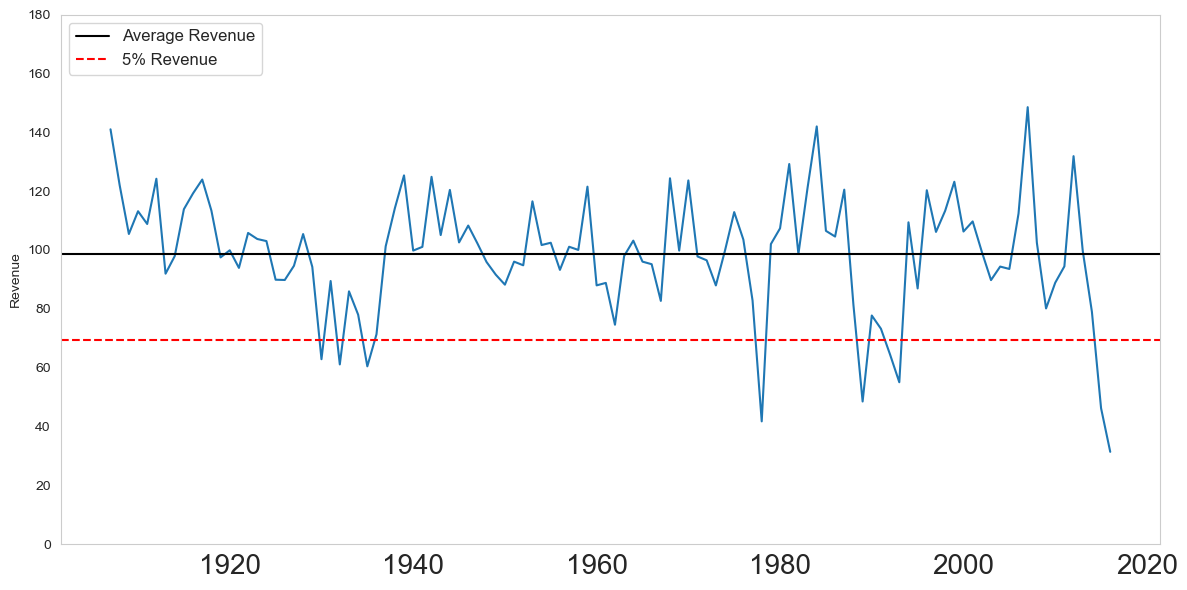

In [ ]:
Yearly_revenue['year'] = pd.date_range(start='1906', periods=110, freq='Y')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(Yearly_revenue['year'], Yearly_revenue['Annual Revenue'])
mean = Yearly_revenue['Annual Revenue'].mean()
lowpercentile = Yearly_revenue['Annual Revenue'].quantile(0.08)
plt.axhline(y=mean, color='black', linestyle='-', label='Average Revenue')
plt.axhline(y=lowpercentile, color='r', linestyle='--', label='5% Revenue')
# plt.title('Losthills Daily Revenue from 1906 to 2024')
# plt.xlabel('Year')
# plt.ylabel('Revenue')
plt
plt.ylim(0, 180)
plt.xticks(fontsize=20) 
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

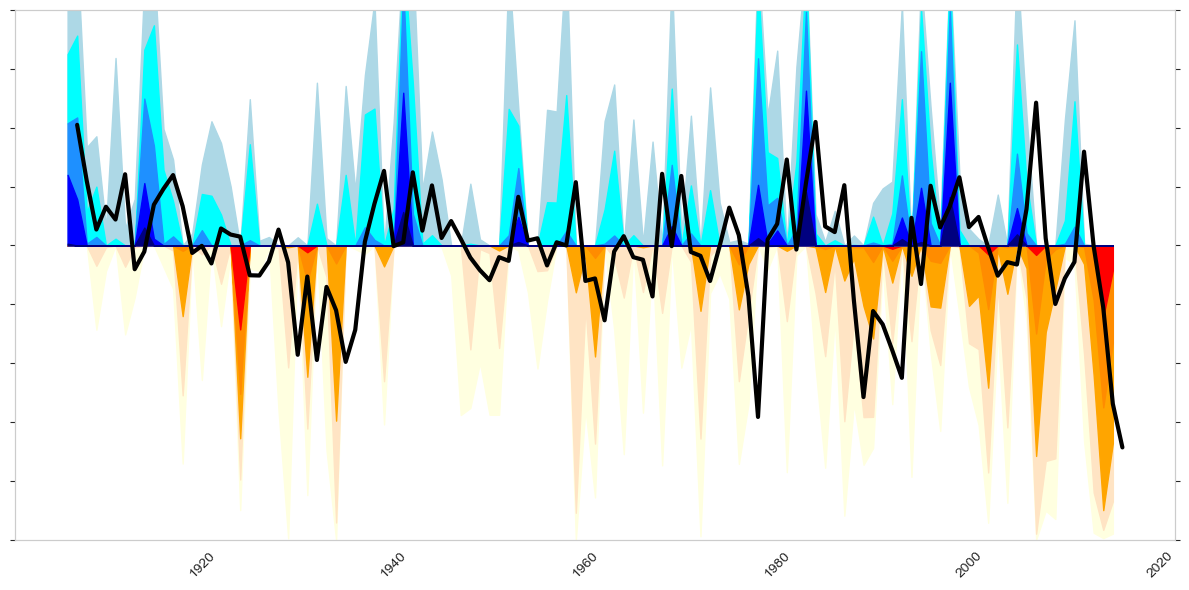

In [ ]:
df = pd.read_csv('calfews_src/data/price_index/PALEO-California.csv')
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y')
df = df[(df['DATE'] >= '1906') & (df['DATE'] < '2016')]

# Assume Yearly_revenue is a DataFrame already loaded in your environment
Yearly_revenue['year'] = pd.date_range(start='1906', periods=len(Yearly_revenue), freq='Y')
# Yearly_revenue = Yearly_revenue[(Yearly_revenue['year'] >= '2000-01-01') & (Yearly_revenue['year'] < '2016-12-01')]

# Create the figure and the first subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot the drought severity time series
ax1.fill_between(df['DATE'], df['D0'], color='lightyellow', label='D0 - Abnormally Dry')
ax1.fill_between(df['DATE'], df['D1'], df['D2'], color='bisque', label='D1 - Moderate Drought')
ax1.fill_between(df['DATE'], df['D2'], df['D3'], color='orange', label='D2 - Severe Drought')
ax1.fill_between(df['DATE'], df['D3'], df['D4'], color='darkorange', label='D3 - Extreme Drought')
ax1.fill_between(df['DATE'], df['D4'], color='red', label='D4 - Exceptional Drought')
ax1.fill_between(df['DATE'], -df['W0'], color='lightblue', label='W0 - Abnormally Wet')
ax1.fill_between(df['DATE'], -df['W1'], -df['W2'], color='cyan', label='W1 - Moderate Wetness')
ax1.fill_between(df['DATE'], -df['W2'], -df['W3'], color='dodgerblue', label='W2 - Significant Wetness')
ax1.fill_between(df['DATE'], -df['W3'], -df['W4'], color='blue', label='W3 - Very Wet')
ax1.fill_between(df['DATE'], -df['W4'], color='navy', label='W4 - Extremely Wet')

# ax1.set_ylabel('Percentage of Area in Drought (%)', fontsize=16)
# ax1.set_title('Drought Severity and Index Price Time Series for CA (1906-2015)')
# ax1.yaxis.set_tick_params(labelsize=16)
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.legend(loc='lower left', fontsize=14)
ax1.set_yticklabels([])
plt.xticks(rotation=45)
ax1.set_ylim(-80, 100)
ax1.invert_yaxis() 
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(Yearly_revenue['year'], Yearly_revenue['Annual Revenue'], color='black', linewidth=3,label='Annual Revenue')
mean = Yearly_revenue['Annual Revenue'].mean()
lowpercentile = Yearly_revenue['Annual Revenue'].quantile(0.08)
# ax2.axhline(y=mean, color='black', linestyle='-', label='Average Revenue')
# ax2.axhline(y=lowpercentile, color='r', linestyle='--', label='5% Revenue')

# ax2.set_ylabel('Revenue', fontsize=16)
# ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_ylim(0, 180)
# ax2.legend(loc='upper right', fontsize=12
ax2.set_yticklabels([])
ax2.grid(False)

plt.tight_layout()
# plt.savefig('plots/drought_severity_and_revenue.png', dpi=300, transparent =True)
plt.show()

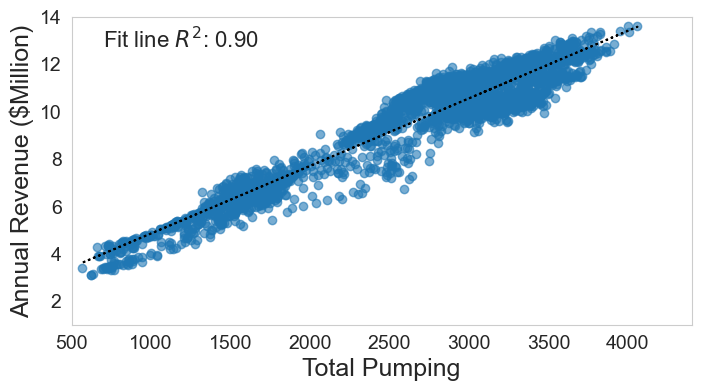

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
read_file = 'plots/pumping_vs_revenue_losthills_1yr.csv'
read_file= pd.read_csv(read_file, index_col=0, parse_dates=True)
y = read_file['Annual Revenue']
x = read_file['Total Pumping']
corr_coef = np.corrcoef(x, y)[0, 1]
r_squared = corr_coef ** 2
ax.scatter(x, y, alpha=0.6, label='All data')

slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept  # This is the line equation
plt.plot(x, line, 'black', linestyle= ':', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')

ax.annotate(f"Fit line $R^2$: {r_squared:.2f}", xy=(0.05, 0.90), xycoords='axes fraction',
                    fontsize=16, bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))
# ax.set_title(f"{district.capitalize()} ({years_to_include}-Year)")
ax.set_xlabel("Total Pumping",  fontsize=18)
ax.set_ylabel("Annual Revenue ($Million)",  fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(False)
ax.set_ylim(1, 14)
ax.set_xlim(500, 4400)
plt.show()

# Intial condition and net payout 

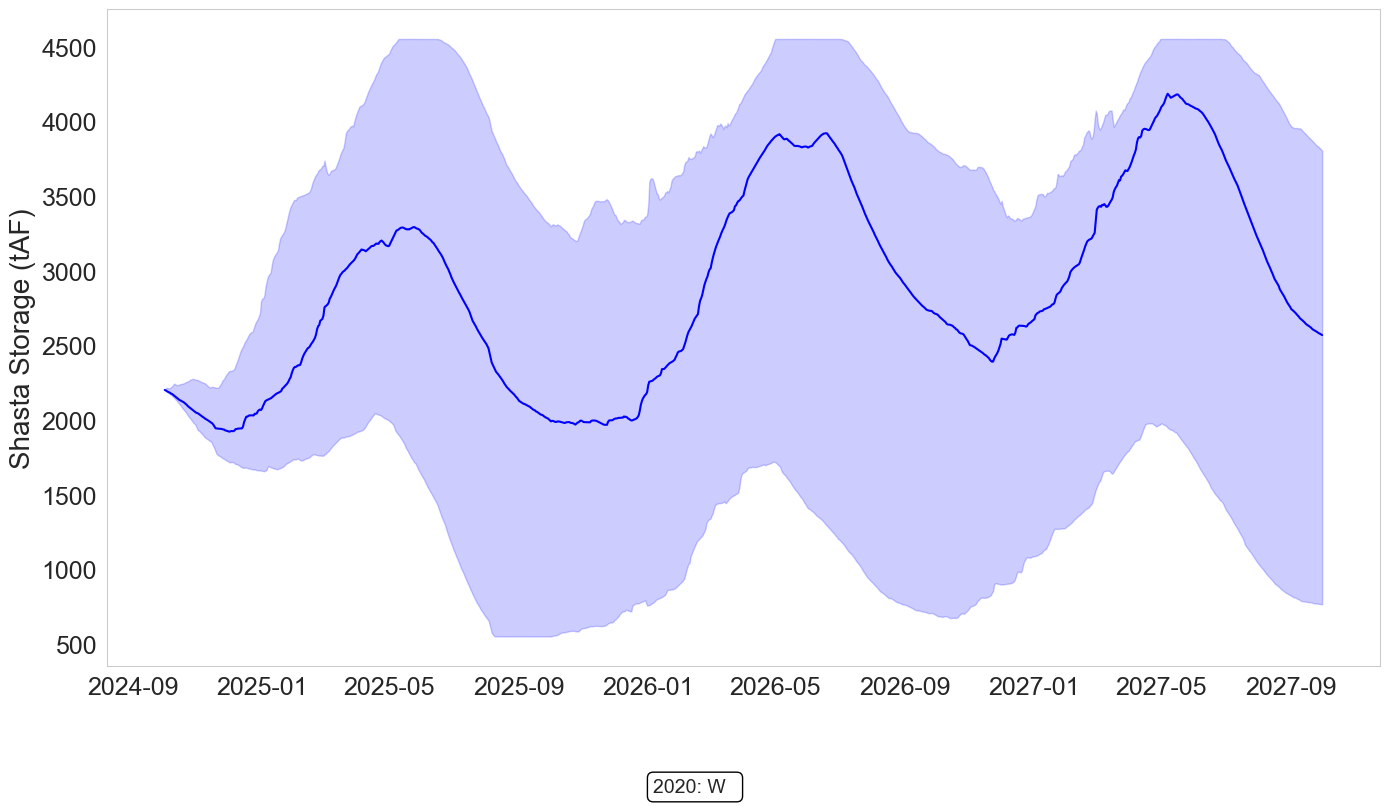

In [ ]:
base_output_folder = "results/startyear_4_1"
start_year = 2020
end_year = 2020

yearly_medians = {}
yearly_25 = {}
yearly_75 = {}

for year in range(start_year, end_year + 1):
    all_simulations = []
    
    for i in range(1, 101): 
        trace_file = os.path.join(base_output_folder, f"{year}_{i}", 'results.hdf5')
        data = get_results_sensitivity_number_outside_model(trace_file, '')
        all_simulations.append(data['shasta_S'])
    
    sim_df = pd.concat(all_simulations, axis=1)
    yearly_medians[year] = sim_df.median(axis=1)
    yearly_25[year] = sim_df.quantile(0.10, axis=1)
    yearly_75[year] = sim_df.quantile(0.95, axis=1)

median_df = pd.DataFrame(yearly_medians)
p25_df = pd.DataFrame(yearly_25)
p75_df = pd.DataFrame(yearly_75)

plt.figure(figsize=(14, 8))

water_year_types = "W W W AN AN D D BN D W W C C BN AN W D C C C D W BN W D C C W W"
year_types = water_year_types.split()

color_map = {
    'W': 'blue',       # Wet
    'AN': 'royalblue', # Above Normal
    'BN': 'yellow',    # Below Normal
    'D': 'orange',     # Dry
    'C': 'red'         # Critical
}
type_names = {
    'W': 'Wet',
    'AN': 'Above Normal',
    'BN': 'Below Normal',
    'D': 'Dry',
    'C': 'Critical'
}
legend_handles = {}

for i, year in enumerate(range(start_year, end_year + 1)):
    if year in median_df.columns:
        year_type = year_types[i]
        color = color_map[year_type]
        
        line = plt.plot(median_df[year], 
                 color='blue', 
                 label=f'{year} ({year_type})')

        plt.fill_between(median_df.index, p25_df[year], p75_df[year], color='blue', alpha=0.2)
        
        if year_type not in legend_handles:
            legend_handles[year_type] = line[0]

# plt.title('Median Shasta Storage Across 100 Simulations (1996-2024)')
plt.ylabel('Shasta Storage (tAF)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(False)

# first_legend = plt.legend(handles=list(legend_handles.values()), 
#                          labels=[f"{k} - {type_names[k]}" for k in legend_handles.keys()],
#                          loc='lower right', fontsize=14)
# plt.gca().add_artist(first_legend)

years_text = ""
for i, year in enumerate(range(start_year, end_year + 1)):
    years_text += f"{year}: {year_types[i]}  "
    if (i+1) % 5 == 0:
        years_text += "\n"

plt.figtext(0.5, -0.03, years_text, ha='center', fontsize=14, va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
# plt.savefig(f'plots/shasta_storage_{year}.png', transparent=True) #, transparent=True
plt.show()

In [10]:
base_output_folder = "results/startyear_4_1"
start_year = 1996
end_year = 2024

yearly_medians = {}

for year in range(start_year, end_year + 1):
    all_simulations = []
    
    for i in range(1, 101): 
        trace_file = os.path.join(base_output_folder, f"{year}_{i}", 'results.hdf5')
        data = get_results_sensitivity_number_outside_model(trace_file, '')
        all_simulations.append(data['shasta_S'])
        # all_simulations.append(data['delta_HRO_pump'].resample('AS-OCT').sum())

    sim_df = pd.concat(all_simulations, axis=1)
    yearly_medians[year] = sim_df.median(axis=1)
median_df = pd.DataFrame(yearly_medians)


In [9]:
plt.figure(figsize=(14, 8))

water_year_types = "W W W AN AN D D BN D W W C C BN AN W D C C C D W BN W D C C W W"
year_types = water_year_types.split()

color_map = {
    'W': 'blue',       # Wet
    'AN': 'royalblue', # Above Normal
    'BN': 'yellow',      # Below Normal
    'D': 'orange',     # Dry
    'C': 'red'         # Critical
}
type_names = {
    'W': 'Wet',
    'AN': 'Above Normal',
    'BN': 'Below Normal',
    'D': 'Dry',
    'C': 'Critical'
}
legend_handles = {}

for i, year in enumerate(range(start_year, end_year + 1)):
    if year in median_df.columns:
        year_type = year_types[i]
        color = color_map[year_type]
        
        line = plt.plot(median_df[year], 
                 color=color, 
                 label=f'{year} ({year_type})')
        
        if year_type not in legend_handles:
            legend_handles[year_type] = line[0]

# plt.title('Median Shasta Storage Across 100 Simulations (1996-2024)')
plt.ylabel('Shasta Storage (tAF)', fontsize = 20)
# plt.xticks(fontsize = 14)
plt.yticks(fontsize = 18)


plt.grid(False)
order = ['W', 'AN', 'BN', 'D', 'C'] 
sorted_handles = sorted(legend_handles.items(), key=lambda x: order.index(x[0]))

first_legend = plt.legend(handles=[item[1] for item in sorted_handles], 
                          labels=[f"{type_names[k]}" for k, _ in sorted_handles],
                          loc='lower right', fontsize=18)
plt.gca().add_artist(first_legend)

# Add a separate text annotation for the year mapping
years_text = ""
for i, year in enumerate(range(start_year, end_year + 1)):
    years_text += f"{year}: {year_types[i]}  "
    if (i+1) % 5 == 0:  # Line break every 5 years
        years_text += "\n"

plt.figtext(0.5, -0.03, years_text, ha='center', fontsize = 14, va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for the text at the bottom
# plt.savefig(f'plots/shasta_storage_ensemble.png') #, transparent=True
plt.show()


NameError: name 'median_df' is not defined

<Figure size 1400x800 with 0 Axes>

# payout and premium

In [2]:
import numpy as np
from scipy.stats import norm
import scipy.stats as st


def simple_wang_transform(payouts, lam= -0.25):
    """
    Apply a simplified Wang transform to an input tuple of payouts and return both
    the transformed payout (premium) and the net position (whole).

    :param payouts: A tuple of payout values.
    :param lam: Lambda parameter for the Wang transform (risk adjustment).
    :param from_user: Boolean flag for determining perspective (user's or insurer's).
    :return: A tuple containing the transformed payout (premium) and the whole.
    """
    payouts = pd.DataFrame(payouts, columns=['payout'])
    unique_pays = pd.DataFrame()
    unique_pays['unique'] = payouts.payout.unique()
    unique_pays['prob'] = 0 
    for j in range(len(unique_pays)):  
        count = 0
        val = unique_pays['unique'].iloc[j]
        for i in np.arange(len(payouts)): 
            if payouts['payout'].iloc[i] == val: 
                count += 1
        unique_pays['prob'].iloc[j] = count/len(payouts)
    unique_pays.sort_values(inplace=True, by='unique')
    dum = unique_pays['prob'].cumsum()  # asset cdf
    dum = st.norm.cdf(st.norm.ppf(dum) - 0.25)  # risk transformed payout cdf
    dum = np.append(dum[0], np.diff(dum))  # risk transformed asset pdf
    prem = (dum * unique_pays['unique']).sum()


    whole = payouts - prem

    return prem


In [272]:
# base_output_folder = "results/startyear_4_1"
# start_year = 1996
# end_year = 2024
# all_first_years_data = []
# all_second_years_data = []
# all_third_years_data = []

# for year in range(start_year, end_year + 1):
#     for i in range(1, 101):
#         trace_file = os.path.join(base_output_folder, f"{year}_{i}", 'results.hdf5')
#         data = get_results_sensitivity_number_outside_model(trace_file, '')
#         delta_HRO_pump_resampled = data['delta_HRO_pump'].resample('AS-OCT').sum()
        
#         first_year_value = delta_HRO_pump_resampled.iloc[0]
#         second_year_value = delta_HRO_pump_resampled.iloc[1]
#         third_year_value = delta_HRO_pump_resampled.iloc[2]
#         all_first_years_data.append(first_year_value)
#         all_second_years_data.append(second_year_value)
#         all_third_years_data.append(third_year_value)

# mean_value = np.mean(all_first_years_data + all_second_years_data + all_third_years_data)

# print("Mean value of all years:", mean_value)
# import pickle
# with open('calfews_src/data/mean_value.pkl', 'wb') as f:
#     pickle.dump(mean_value, f)

In [445]:
base_output_folder = "plots/pumping_vs_revenue_KCWA_3yr.csv"
start_year = 1996
end_year = 2024
slope = slope_kcwa

# with open('calfews_src/data/mean_value.pkl', 'rb') as f:
#     mean_value = pickle.load(f)
mean_value = 2700 
strike_90 = 0.9 * mean_value
strike_80 = 0.7 * mean_value
strike_70 = 0.5 * mean_value

expectation_of_payouts = []
expectation_of_payouts_2y = []
expectation_of_payouts_3y = []
premium_1yr = []
premium_2yr = []
premium_3yr = []

for year in range(start_year, end_year + 1):
    all_first_years_data = []
    all_second_years_data = []
    all_third_years_data = []

    for i in range(1, 101):
        trace_file = pd.read_csv(base_output_folder)
        #when year is year and simulation is i get the value for column Total Pumping
        delta_HRO_pump_resampled = trace_file['Total Pumping'][(trace_file['Year'] == year) & (trace_file['Simulation'] == i)]
        # print(delta_HRO_pump_resampled)
        
        first_year_value = delta_HRO_pump_resampled.iloc[0]
        second_year_value = delta_HRO_pump_resampled.iloc[1]
        third_year_value = delta_HRO_pump_resampled.iloc[2]
        all_first_years_data.append(first_year_value)
        all_second_years_data.append(second_year_value)
        all_third_years_data.append(third_year_value)

    payouts_90_1yr = [slope * max((strike_90 - f), 0) for f in all_first_years_data]
    # print(f"payouts_90_1yr: {payouts_90_1yr}")
    payouts_80_1yr = [slope * max((strike_80 - f), 0) for f in all_first_years_data]
    payouts_70_1yr = [slope * max((strike_70 - f), 0) for f in all_first_years_data]
    payouts_90_2yr = [slope * max((strike_90 - f), 0) for f in all_second_years_data]
    payouts_80_2yr = [slope * max((strike_80 - f), 0) for f in all_second_years_data]
    payouts_70_2yr = [slope * max((strike_70 - f), 0) for f in all_second_years_data]
    payouts_90_3yr = [slope * max((strike_90 - f), 0) for f in all_third_years_data]
    payouts_80_3yr = [slope * max((strike_80 - f), 0) for f in all_third_years_data]
    payouts_70_3yr = [slope * max((strike_70 - f), 0) for f in all_third_years_data]

    payouts_90_2yr_combined = [a + b for a, b in zip(payouts_90_2yr, payouts_90_1yr)]
    payouts_80_2yr_combined = [a + b for a, b in zip(payouts_80_2yr, payouts_80_1yr)]
    payouts_70_2yr_combined = [a + b for a, b in zip(payouts_70_2yr, payouts_70_1yr)]
    payouts_90_3yr_combined = [a + b + c for a, b, c in zip(payouts_90_3yr, payouts_90_2yr, payouts_90_1yr)]
    payouts_80_3yr_combined = [a + b + c for a, b, c in zip(payouts_80_3yr, payouts_80_2yr, payouts_80_1yr)]
    payouts_70_3yr_combined = [a + b + c for a, b, c in zip(payouts_70_3yr, payouts_70_2yr, payouts_70_1yr)]

    premium_90_1yr = simple_wang_transform(payouts_90_1yr)
    premium_80_1yr = simple_wang_transform(payouts_80_1yr)
    premium_70_1yr = simple_wang_transform(payouts_70_1yr)
    premium_90_2yr = simple_wang_transform(payouts_90_2yr_combined)
    premium_80_2yr = simple_wang_transform(payouts_80_2yr_combined)
    premium_70_2yr = simple_wang_transform(payouts_70_2yr_combined)
    premium_90_3yr = simple_wang_transform(payouts_90_3yr_combined)
    premium_80_3yr = simple_wang_transform(payouts_80_3yr_combined)
    premium_70_3yr = simple_wang_transform(payouts_70_3yr_combined)

    expectation_payout_90_1yr = np.mean(payouts_90_1yr)
    expectation_payout_80_1yr = np.mean(payouts_80_1yr)
    expectation_payout_70_1yr = np.mean(payouts_70_1yr)
    expectation_payout_90_2yr = np.mean(payouts_90_2yr_combined)
    expectation_payout_80_2yr = np.mean(payouts_80_2yr_combined)
    expectation_payout_70_2yr = np.mean(payouts_70_2yr_combined)
    expectation_payout_90_3yr = np.mean(payouts_90_3yr_combined)
    expectation_payout_80_3yr = np.mean(payouts_80_3yr_combined)
    expectation_payout_70_3yr = np.mean(payouts_70_3yr_combined)

    expectation_of_payouts.append((expectation_payout_90_1yr, expectation_payout_80_1yr, expectation_payout_70_1yr))
    expectation_of_payouts_2y.append((expectation_payout_90_2yr, expectation_payout_80_2yr, expectation_payout_70_2yr))
    expectation_of_payouts_3y.append((expectation_payout_90_3yr, expectation_payout_80_3yr, expectation_payout_70_3yr))

    premium_1yr.append((premium_90_1yr, premium_80_1yr, premium_70_1yr))
    premium_2yr.append((premium_90_2yr, premium_80_2yr, premium_70_2yr))
    premium_3yr.append((premium_90_3yr, premium_80_3yr, premium_70_3yr))


# Convert to arrays for easy plotting
expectation_payout_90s, expectation_payout_80s, expectation_payout_70s = zip(*expectation_of_payouts)
expectation_payout_90_2yr, expectation_payout_80_2yr, expectation_payout_70_2yr = zip(*expectation_of_payouts_2y)
expectation_payout_90_3yr, expectation_payout_80_3yr, expectation_payout_70_3yr = zip(*expectation_of_payouts_3y)

premium_90_1yr, premium_80_1yr, premium_70_1yr = zip(*premium_1yr)
premium_90_2yr, premium_80_2yr, premium_70_2yr = zip(*premium_2yr)
premium_90_3yr, premium_80_3yr, premium_70_3yr = zip(*premium_3yr)

In [ ]:
tup = tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_90s) - np.array(premium_90_1yr))
sum(tup) / len(tup)


88.15022736329018

In [352]:
tup = tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_80s) - np.array(premium_80_1yr))
sum(tup) / len(tup)

89.01228575378354

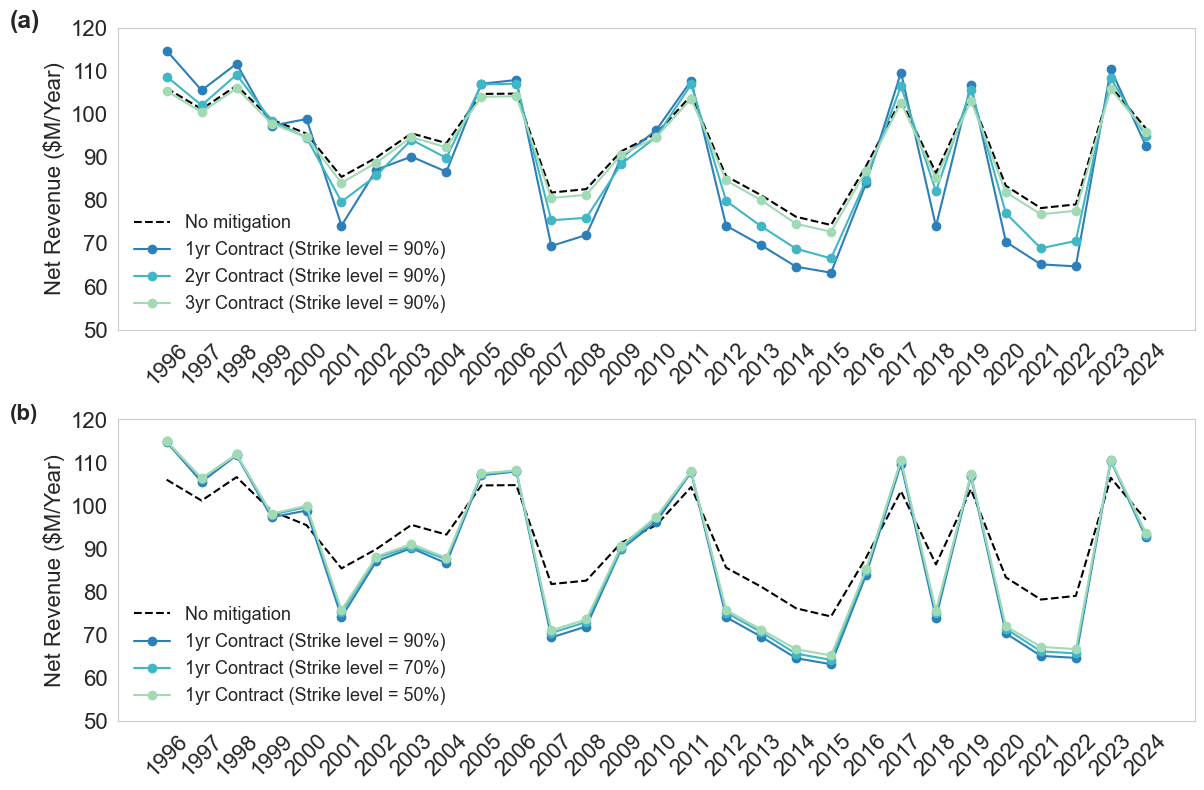

In [449]:
plt.figure(figsize=(12, 8))
years = np.arange(start_year, end_year + 1)
x_indices = np.arange(len(years))
avg_rev_3yr =group_sorted.groupby(['Year'])['Total Annual Revenue'].mean()
plt.subplot(211)
plt.plot(years, tuple(np.array(avg_rev_3yr)), label='No mitigation',color ='black', linestyle='--')
plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_90s) - np.array(premium_90_1yr)), label='1yr Contract (Strike level = 90%)', marker='o', color='#2c7fb8')
plt.plot(years, tuple(np.array(filtered_2y['Total Annual Revenue']) + np.array(expectation_payout_90_2yr)/2 - np.array(premium_90_2yr)/2), label='2yr Contract (Strike level = 90%)', marker='o', color='#41b6c4')
plt.plot(years, tuple(np.array(filtered_3y['Total Annual Revenue']) + np.array(expectation_payout_90_3yr)/3 - np.array(premium_90_3yr)/3), label='3yr Contract (Strike level = 90%)', marker='o', color='#a1dab4')
plt.ylabel('Net Revenue ($M/Year)', fontsize=16)
plt.xticks(years, fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.ylim(50, 120)
plt.legend(fontsize=13, framealpha=0.2, frameon=False)
plt.grid(False)
plt.text(-0.1, 1, '(a)', transform=plt.gca().transAxes, fontsize=18, fontweight='bold')

plt.subplot(212)
plt.plot(years, tuple(np.array(avg_rev_3yr)), label='No mitigation',color ='black', linestyle='--')
plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_90s) - np.array(premium_90_1yr)), label='1yr Contract (Strike level = 90%)', marker='o', color='#2c7fb8')
plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue'])+ np.array(expectation_payout_80s) - np.array(premium_80_1yr)), label='1yr Contract (Strike level = 70%)', marker='o', color='#41b6c4')
plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue'])+ np.array(expectation_payout_70s) - np.array(premium_70_1yr)), label='1yr Contract (Strike level = 50%)', marker='o', color='#a1dab4')

plt.ylabel('Net Revenue ($M/Year)', fontsize=16)
plt.xticks(years, fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.ylim(50, 120)
plt.legend(fontsize=13, framealpha=0.2, frameon=False)  
plt.grid(False)
plt.text(-0.1, 1, '(b)', transform=plt.gca().transAxes, fontsize=16, fontweight='bold')
# plt.subplot(313)
# plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_70s) - np.array(premium_70_1yr)), label='1yr Contract (Strike level = 70%)', marker='o', color='#2c7fb8')
# plt.plot(years, tuple(np.array(filtered_2y['Total Annual Revenue']) + np.array(expectation_payout_70_2yr)/2 - np.array(premium_70_2yr)/2), label='2yr Contract (Strike level = 70%)', marker='o',color='#41b6c4')
# plt.plot(years, tuple(np.array(filtered_3y['Total Annual Revenue']) + np.array(expectation_payout_70_3yr)/3 - np.array(premium_70_3yr)/3), label='3yr Contract (Strike level = 70%)', marker='o', color='#a1dab4')

# plt.ylabel('Net Payout ($M/Year)', fontsize=16)
# # plt.title('Expectation of Payouts per Contract Period', fontsize=18)
# plt.xticks(years, fontsize=14, rotation=45)
# plt.yticks(fontsize=16)
# # plt.ylim(-0.35, 0.05)
# plt.legend(fontsize=10)
# plt.grid(False)
plt.tight_layout()

plt.show()

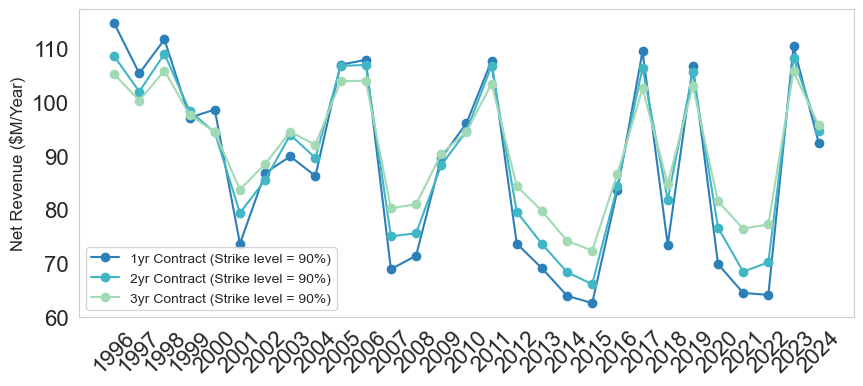

In [18]:
plt.figure(figsize=(10, 4))
start_year = 1996
end_year = 2024
years = np.arange(start_year, end_year + 1)

plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_90s) - np.array(premium_90_1yr)), label='1yr Contract (Strike level = 90%)', marker='o', color='#2c7fb8')
plt.plot(years, tuple(np.array(filtered_2y['Total Annual Revenue']) + np.array(expectation_payout_90_2yr)/2 - np.array(premium_90_2yr)/2), label='2yr Contract (Strike level = 90%)', marker='o', color='#41b6c4')
plt.plot(years, tuple(np.array(filtered_3y['Total Annual Revenue']) + np.array(expectation_payout_90_3yr)/3 - np.array(premium_90_3yr)/3), label='3yr Contract (Strike level = 90%)', marker='o', color='#a1dab4')
# plt.plot(years, premium_90_1yr, color='red', linestyle='--', linewidth=1, label='Mark Year: premium_90_1yr')
# plt.plot(years, premium_90_2yr, color='orange', linestyle='--', linewidth=1, label='Mark Year: premium_90_2yr')
# plt.plot(years, premium_90_3yr, color='darkgreen', linestyle='--', linewidth=1, label='Mark Year: premium_90_3yr')
plt.ylabel('Net Revenue ($M/Year)', fontsize=12)
plt.xticks(years, fontsize=16, rotation=45)
plt.yticks(fontsize=16)
# plt.ylim(-0.35, 0.05)
plt.legend(fontsize=10)
plt.grid(False)

In [388]:
def calculate_payout(total_pumping, slope, strike_90):
    return slope * max(strike_90 - total_pumping, 0)

# calculate payout & premium for each insurance group
group_sorted['payout'] = group_sorted['Total Pumping'].apply(lambda x: calculate_payout(x, slope, strike_90))
year_premium_map_1y = {year: premium for year, premium in zip(range(1996, 2025), np.array(premium_90_1yr))} 
year_premium_map_2y = {year: premium for year, premium in zip(range(1996, 2025), np.array(premium_90_2yr)/2)}
year_premium_map_3y = {year: premium for year, premium in zip(range(1996, 2025), np.array(premium_90_3yr)/3)}
group_sorted['premium_1y'] = group_sorted['Year'].map(year_premium_map_1y)
group_sorted['premium_2y'] = group_sorted['Year'].map(year_premium_map_2y)
group_sorted['premium_3y'] = group_sorted['Year'].map(year_premium_map_3y)
group_sorted['STR2_index_insurance_1y'] = group_sorted['Total Annual Revenue'] + group_sorted['payout']- group_sorted['premium_1y']
group_sorted['STR2_index_insurance_2y'] = group_sorted['Total Annual Revenue'] + group_sorted['payout']- group_sorted['premium_2y']
group_sorted['STR2_index_insurance_3y'] = group_sorted['Total Annual Revenue'] + group_sorted['payout']- group_sorted['premium_3y']

def calculate_contingency_fund(revenue_series, initial_fund, target_revenue):
    n = len(revenue_series)
    contingency_fund = [initial_fund]  # Starting fund at initial level (CF0)
    
    for i in range(1, n):
        previous_fund = contingency_fund[i-1]
        previous_revenue = revenue_series[i-1]
        
        cf_next = min(max(previous_fund + previous_revenue - min(target_revenue, previous_fund + previous_revenue), 0), initial_fund)
        contingency_fund.append(cf_next)
    
    return contingency_fund

def calculate_annual_cost_cf(initial_fund, interest_rate=0.05, years=3):
    r = interest_rate
    n = years
    annual_cost = initial_fund * (r * (1 + r) ** n) / ((1 + r) ** n - 1)
    # print(f"Annual cost of the fund: {annual_cost/initial_fund:.2%} of the initial fund")
    return annual_cost
def calculate_CF_cost(group_sorted, initial_fund, target_revenue=92):
    results = []
    
    for i in range(0, len(group_sorted), 3):
        scenario = group_sorted.iloc[i:i+3]
        revenue_series = scenario['Total Annual Revenue'].values
        contingency_funds = calculate_contingency_fund(revenue_series, initial_fund, target_revenue)
        annual_cost = calculate_annual_cost_cf(initial_fund)
        
        for j in range(3):
            contingency_fund_revenue = initial_fund - contingency_funds[j] - annual_cost
            results.append(contingency_fund_revenue)
    
    return results

In [400]:
#STR1 contignency fund
group_sorted['CF1_revenue'] = calculate_CF_cost(group_sorted, target_revenue * 0.8)
group_sorted['STR1_CF_only'] = group_sorted['CF1_revenue'] + group_sorted['Total Annual Revenue']

# STR3 hybrid insurance
group_sorted['CF2_revenue'] = calculate_CF_cost(group_sorted, target_revenue * 0.3)
group_sorted['STR3_inr_payout'] = group_sorted['Total Pumping'].apply(lambda x: calculate_payout(x, slope, strike_70))
year_premium_map = {year: premium for year, premium in zip(range(1996, 2025), np.array(premium_70_2yr)/2)}
group_sorted['STR3_premium'] = group_sorted['Year'].map(year_premium_map)
group_sorted['STR3_hybrid'] = group_sorted['Total Annual Revenue'] + group_sorted['CF2_revenue'] + group_sorted['STR3_inr_payout'] - group_sorted['STR3_premium'] 


group_sorted.head(25)


,Year,Simulation,Total Pumping,Total Annual Revenue,GroupNumber,CF1_revenue,STR1_CF_only,CF2_revenue,STR3_inr_payout,STR3_premium,STR3_hybrid,payout,premium_1y,premium_2y,premium_3y,STR2_index_insurance_1y,STR2_index_insurance_2y,STR2_index_insurance_3y
0,1996,1,3271.996763,107.383530,1,-27.026550,80.356979,-10.134956,0.000000,0.27606,96.972513,0.000000,0.509882,2.564098,4.338095,106.873648,104.819432,103.045435
1,1996,1,3650.627788,127.913332,2,-27.026550,100.886781,-10.134956,0.000000,0.27606,117.502315,0.000000,0.509882,2.564098,4.338095,127.403450,125.349233,123.575236
2,1996,1,3079.575652,120.738186,3,-27.026550,93.711636,-10.134956,0.000000,0.27606,110.327169,0.000000,0.509882,2.564098,4.338095,120.228304,118.174088,116.400091
3,1996,2,3246.227921,111.015873,1,-27.026550,83.989323,-10.134956,0.000000,0.27606,100.604856,0.000000,0.509882,2.564098,4.338095,110.505992,108.451775,106.677778
4,1996,2,3368.090802,114.107345,2,-27.026550,87.080795,-10.134956,0.000000,0.27606,103.696328,0.000000,0.509882,2.564098,4.338095,113.597463,111.543247,109.769250
5,1996,2,2961.953422,134.796910,3,-27.026550,107.770359,-10.134956,0.000000,0.27606,124.385893,0.000000,0.509882,2.564098,4.338095,134.287028,132.232812,130.458815
6,1996,3,3229.244600,94.536692,1,-27.026550,67.510142,-10.134956,0.000000,0.27606,84.125675,0.000000,0.509882,2.564098,4.338095,94.026811,91.972594,90.198597
7,1996,3,2501.792189,70.501556,2,-27.026550,43.475006,-10.134956,0.000000,0.27606,60.090539,0.000000,0.509882,2.564098,4.338095,69.991674,67.937458,66.163461
8,1996,3,2949.886379,105.249010,3,-5.528106,99.720904,11.363488,0.000000,0.27606,116.336437,0.000000,0.509882,2.564098,4.338095,104.739129,102.684912,100.910915
9,1996,4,3105.636655,96.107491,1,-27.026550,69.080941,-10.134956,0.000000,0.27606,85.696474,0.000000,0.509882,2.564098,4.338095,95.597609,93.543393,91.769396


 STR0 (No protection): Mean: 92.41 Million, Bottom 5%: 44.76 Million
 STR1 (Contingency fund only): Mean: 75.45 Million, Bottom 5%: 30.93 Million
 STR2 (Parametric insurance only):Mean:  90.06 Million, Bottom 5%: 55.61 Million
 STR3 (Hybrid (Insurance + CF)): Mean:  90.38 Million, Bottom 5%: 49.75 Million


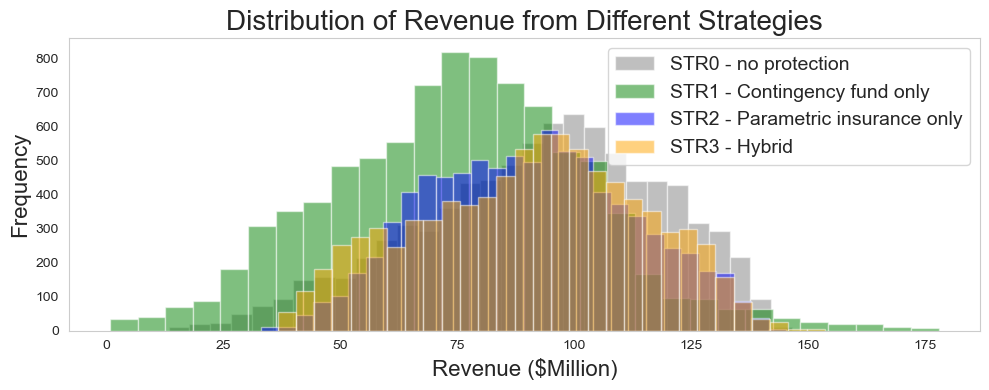

In [398]:
#plot distribution of STR2_rev_insurance, STR3_hybrid, STR1_rev_CF_only
#also print the mean and bottom 10% of each strategy
mean_STR0 = group_sorted['Total Annual Revenue'].mean()
mean_STR2 = group_sorted['STR2_index_insurance_1y'].mean()
mean_STR3 = group_sorted['STR3_hybrid'].mean()
mean_STR1 = group_sorted['STR1_CF_only'].mean()
bottom_10_STR0 = group_sorted['Total Annual Revenue'].quantile(0.05)
bottom_10_STR2 = group_sorted['STR2_index_insurance_1y'].quantile(0.05)
bottom_10_STR3 = group_sorted['STR3_hybrid'].quantile(0.05)
bottom_10_STR1 = group_sorted['STR1_CF_only'].quantile(0.05)

print(f" STR0 (No protection): Mean: {mean_STR0:.2f} Million, Bottom 5%: {bottom_10_STR0:.2f} Million")
print(f" STR1 (Contingency fund only): Mean: {mean_STR1:.2f} Million, Bottom 5%: {bottom_10_STR1:.2f} Million")
print(f" STR2 (Parametric insurance only):Mean:  {mean_STR2:.2f} Million, Bottom 5%: {bottom_10_STR2:.2f} Million")
print(f" STR3 (Hybrid (Insurance + CF)): Mean:  {mean_STR3:.2f} Million, Bottom 5%: {bottom_10_STR3:.2f} Million")

plt.figure(figsize=(10, 4))
plt.hist(group_sorted['Total Annual Revenue'], bins=30, alpha=0.5, label='STR0 - no protection', color='grey')
plt.hist(group_sorted['STR1_CF_only'], bins=30, alpha=0.5, label='STR1 - Contingency fund only', color='green')
plt.hist(group_sorted['STR2_index_insurance_1y'], bins=30, alpha=0.5, label='STR2 - Parametric insurance only', color='blue')
plt.hist(group_sorted['STR3_hybrid'], bins=30, alpha=0.5, label='STR3 - Hybrid', color='orange')
plt.xlabel('Revenue ($Million)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of Revenue from Different Strategies', fontsize=20)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

In [282]:
# group_sorted.loc[group_sorted['GroupNumber'] != 1, 'STR2_index_insurance_1y'] = None
# group_sorted.loc[~group_sorted['GroupNumber'].isin([1, 2]), 'STR2_index_insurance_2y'] = None
# group_sorted.loc[~group_sorted['GroupNumber'].isin([1, 2, 3]), 'STR2_index_insurance_3y'] = None
# group_sorted

In [ ]:
#90 percentile of STR2_index_insurance_1y, STR2_index_insurance_2y, STR2_index_insurance_3y
print(group_sorted['Total Annual Revenue'].mean())
print(group_sorted['Total Annual Revenue'].quantile(0.20))
print(group_sorted['Total Annual Revenue'].quantile(0.05))
print(group_sorted['Total Annual Revenue'].quantile(0.01))

# print(group_sorted['STR2_index_insurance_1y'].quantile(0.01))
# print(group_sorted['STR2_index_insurance_2y'].quantile(0.01))
# print(group_sorted['STR2_index_insurance_3y'].quantile(0.01))
# print(group_sorted['STR2_index_insurance_1y'].mean()) #renew insurance every year
# print(group_sorted['STR2_index_insurance_2y'].mean()) #renew insurance every 2 years , not rounded up, since i only have 3 year time series!
# print(group_sorted['STR2_index_insurance_3y'].mean()) #renew insurance every 3 years


92.41288241992275
69.8823121301545
44.75766392453089
29.975506789597517


Mean cost for STG 0: 
no protection: $92.41 M
Mean cost for STG 1: 
 Contingency
 fund only: $75.45 M
Mean cost for STG 3: 
 Hybrid: $88.72 M
Mean cost for STG 2: 
 Insurance only
 (1y): $90.06 M
Mean cost for STG 2: 
 Insurance only
 (2y): $91.78 M
Mean cost for STG 2: 
 Insurance only
 (3y): $91.21 M


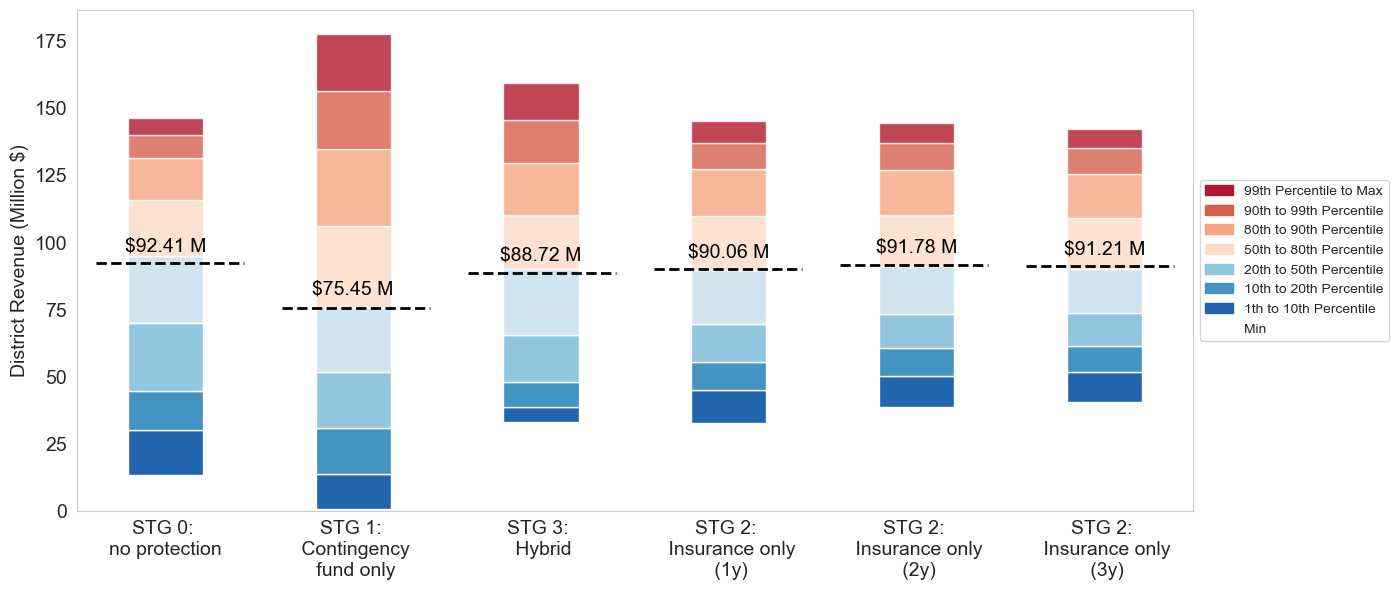

Figure saved as: Figure/index_insurance/strategy_20250613_180952_custom_name.png


In [402]:
dataframes = {
    'STG 0: \nno protection': group_sorted['Total Annual Revenue'],
    'STG 1: \n Contingency\n fund only': group_sorted['STR1_CF_only'],
    'STG 3: \n Hybrid': group_sorted['STR3_hybrid'],
    'STG 2: \n Insurance only\n (1y)': group_sorted['STR2_index_insurance_1y'],
    'STG 2: \n Insurance only\n (2y)': group_sorted['STR2_index_insurance_2y'],
    'STG 2: \n Insurance only\n (3y)': group_sorted['STR2_index_insurance_3y'],
}

# Specify a unique suffix for the filename
unique_filename = plot_water_purchase_costs(dataframes, filename_suffix='custom_name')
print(f"Figure saved as: {unique_filename}")

In [ ]:
target_revenue = 92  # Target revenue
initial_fund = target_revenue*0.5 # Assume the fund is initially seeded with $50,000

results = []
for i in range(0, len(group_sorted), 3):
    scenario = group_sorted.iloc[i:i+3]
    revenue_series = scenario['Total Annual Revenue'].values
    contingency_funds = calculate_contingency_fund(revenue_series, initial_fund, target_revenue)
    annual_cost = calculate_annual_cost_cf(initial_fund)
    for j in range(3):
        contingency_fund_revenue = 46 - contingency_funds[j] - annual_cost
        results.append(contingency_fund_revenue)

# Ensure results length matches the DataFrame length
group_sorted['Contingency_fund_revenue'] = results
group_sorted['STR1_rev_CF_only'] = group_sorted['Contingency_fund_revenue'] + group_sorted['Total Annual Revenue']

group_sorted.head(20)

,Year,Simulation,Total Pumping,Total Annual Revenue,GroupNumber,payout,premium,STR2_rev_insurance,Contingency_fund_revenue,STR1_rev_CF_only
0,1996,1,3271.996763,107.383530,1,0.0,1.007372,106.376158,-2.992366,104.391164
1,1996,1,3650.627788,127.913332,2,0.0,1.007372,126.905959,-2.992366,124.920966
2,1996,1,3079.575652,120.738186,3,0.0,1.007372,119.730814,-2.992366,117.745820
3,1996,2,3246.227921,111.015873,1,0.0,1.007372,110.008501,-2.992366,108.023507
4,1996,2,3368.090802,114.107345,2,0.0,1.007372,113.099973,-2.992366,111.114979
5,1996,2,2961.953422,134.796910,3,0.0,1.007372,133.789537,-2.992366,131.804544
6,1996,3,3229.244600,94.536692,1,0.0,1.007372,93.529320,-2.992366,91.544326
7,1996,3,2501.792189,70.501556,2,0.0,1.007372,69.494184,-2.992366,67.509190
8,1996,3,2949.886379,105.249010,3,0.0,1.007372,104.241638,18.506078,123.755088
9,1996,4,3105.636655,96.107491,1,0.0,1.007372,95.100119,-2.992366,93.115125


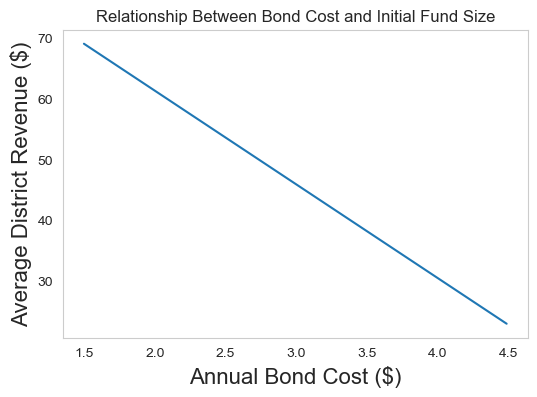

In [67]:
initial_fund_sizes = np.linspace(initial_fund * 0.5, initial_fund * 1.5, num=100)
annual_costs = [calculate_annual_cost_cf(fund) for fund in initial_fund_sizes]
district_rev = target_revenue-initial_fund_sizes   # should be actural district revenue
plt.figure(figsize=(6, 4))
plt.plot(annual_costs, district_rev, label="Annual Cost of Initial Fund")
plt.title("Relationship Between Bond Cost and Initial Fund Size")
plt.ylabel("Average District Revenue ($)", fontsize=16)
plt.xlabel("Annual Bond Cost ($)", fontsize=16)
plt.grid(False)
# plt.legend()
plt.show()

Mean Annual Revenue: 92.41288241992275
5th Percentile Annual Revenue: 44.75766392453089


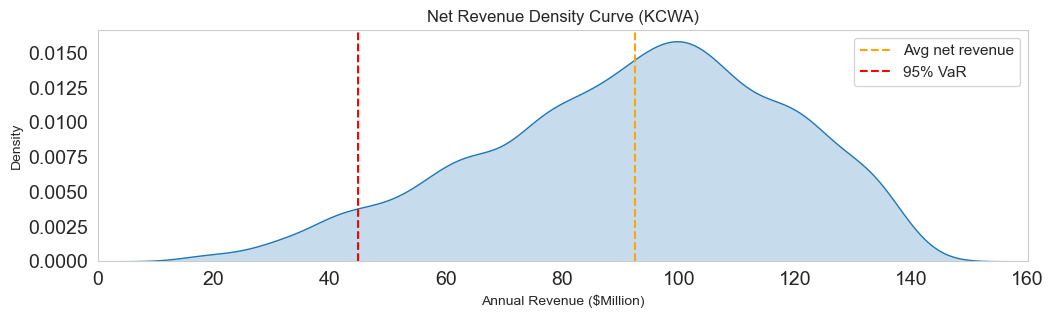

In [29]:
plt.figure(figsize=(12, 3))
sns.kdeplot(group_sorted['Total Annual Revenue'], fill=True)
plt.title("Net Revenue Density Curve (KCWA)")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x = np.mean(group_sorted['Total Annual Revenue']), color='orange', linestyle='--', label='Avg net revenue')
print(f"Mean Annual Revenue: {np.mean(group_sorted['Total Annual Revenue'])}")
first_percentile = np.percentile(group_sorted['Total Annual Revenue'], 5)
print(f"5th Percentile Annual Revenue: {first_percentile}")
plt.axvline(x = first_percentile, color='red', linestyle='--', label='95% VaR')

# plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 160)

plt.legend(fontsize=11, loc ='upper right')
plt.grid(False)
# plt.savefig('plots/net_revenue_density_curve_noContract.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 92.04468282836939
5th Percentile Annual Revenue: 56.42698601562085


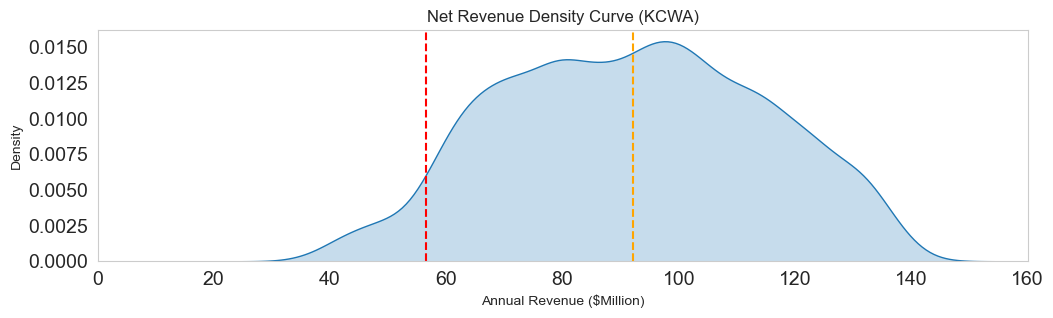

In [27]:

plt.figure(figsize=(12, 3))
sns.kdeplot(group_sorted['net_rev'], fill=True)
plt.title("Net Revenue Density Curve (KCWA)")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x = np.mean(group_sorted['net_rev']), color='orange', linestyle='--', label='Mean')
print(f"Mean Annual Revenue: {np.mean(group_sorted['net_rev'])}")

first_percentile_net = np.percentile(group_sorted['net_rev'], 5)
print(f"5th Percentile Annual Revenue: {first_percentile_net}")
plt.axvline(x = first_percentile_net, color='red', linestyle='--', label='95% VaR')
plt.ylabel("Density")
plt.xlim(0, 160)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
# plt.savefig('plots/net_revenue_density_curve_2yrcontract.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 92.04468282836939
1th Percentile Annual Revenue: 43.57793308243553


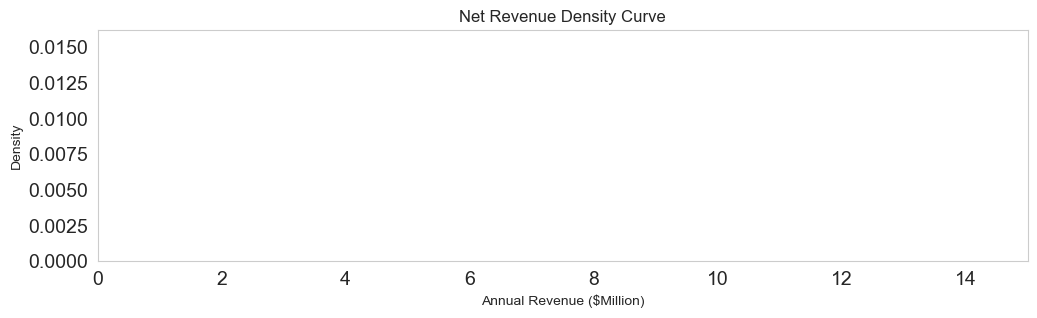

In [28]:


plt.figure(figsize=(12, 3))

sns.kdeplot(group_sorted['net_rev'], fill=True)
plt.title("Net Revenue Density Curve")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x = np.mean(group_sorted['net_rev']), color='orange', linestyle='--', label='Mean')
print(f"Mean Annual Revenue: {np.mean(group_sorted['net_rev'])}")

first_percentile = np.percentile(group_sorted['net_rev'], 1)
print(f"1th Percentile Annual Revenue: {first_percentile}")
plt.axvline(x = first_percentile, color='red', linestyle='--', label='99% VaR')
plt.ylabel("Density")
plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('plots/net_revenue_density_curve_2yrcontract.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 9.339671718005873
1st Percentile Annual Revenue: 4.283896562736899


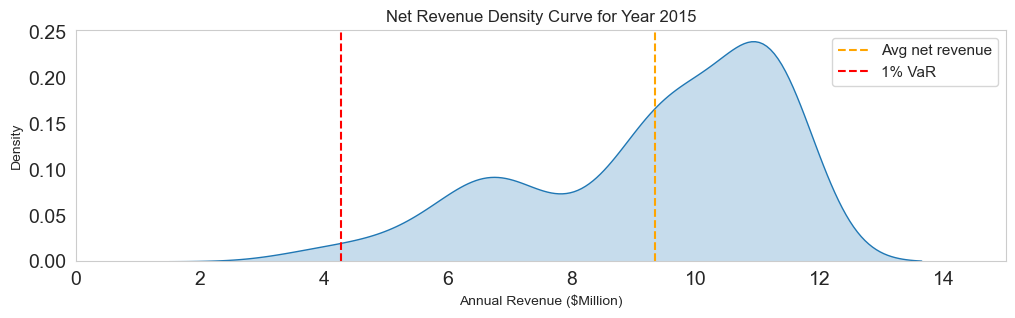

In [22]:
filtered_data = group_sorted[group_sorted['Year'] == 2024]

plt.figure(figsize=(12, 3))
sns.kdeplot(filtered_data['Annual Revenue'], fill=True)
plt.title("Net Revenue Density Curve for Year 2015")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x=np.mean(filtered_data['Annual Revenue']), color='orange', linestyle='--', label='Avg net revenue')
print(f"Mean Annual Revenue: {np.mean(filtered_data['Annual Revenue'])}")

first_percentile = np.percentile(filtered_data['Annual Revenue'], 1)
print(f"1st Percentile Annual Revenue: {first_percentile}")
plt.axvline(x=first_percentile, color='red', linestyle='--', label='1% VaR')

plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='upper right')
plt.grid(False)
plt.savefig('plots/net_revenue_density_curve_2024.png', dpi=300, bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'Total Pumping')

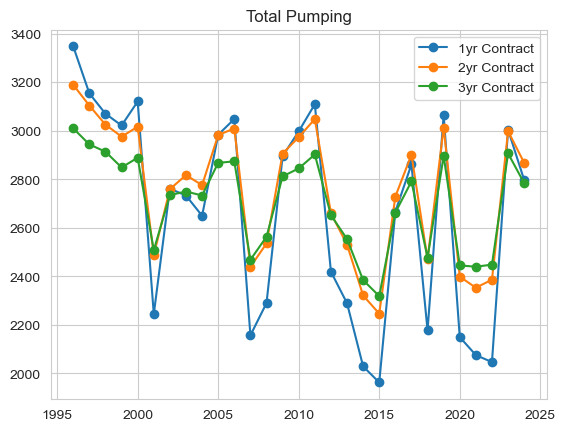

In [47]:
average_revenue_3y = revenue_3y.groupby(['Year','GroupNumber'])['Total Pumping'].mean()
average_revenue_3y = average_revenue_3y.reset_index()
filtered_1y = average_revenue_3y[average_revenue_3y['GroupNumber'] == 1]
filtered_2y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2)]
filtered_2y = filtered_2y.groupby(['Year']).mean().reset_index()
filtered_3y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2) | (average_revenue_3y['GroupNumber'] == 3)]
filtered_3y = filtered_3y.groupby(['Year']).mean().reset_index()
plt.plot(filtered_1y['Year'], filtered_1y['Total Pumping'], label = '1yr Contract', marker='o')
plt.plot(filtered_2y['Year'], filtered_2y['Total Pumping'], label = '2yr Contract', marker='o')
plt.plot(filtered_3y['Year'], filtered_3y['Total Pumping'], label = '3yr Contract', marker='o')
plt.legend()
plt.title('Total Pumping')

# autocorrelation time-series

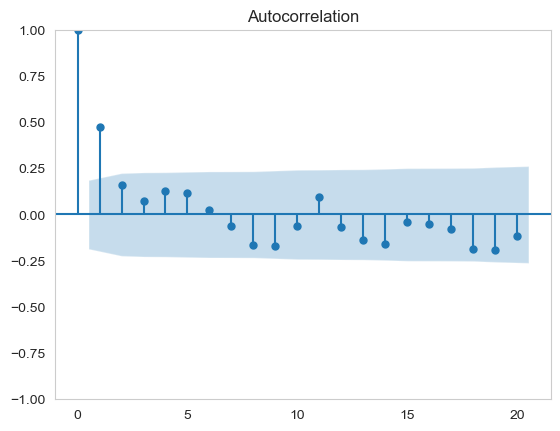

In [30]:
from matplotlib import pyplot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#tranform to standard normal
yearly_pump_data_losthills_nd = (yearly_pump_data_losthills - yearly_pump_data_losthills.mean()) / yearly_pump_data_losthills.std()
plot_acf(yearly_pump_data_losthills_nd, lags=20)
plt.grid(False)
pyplot.show()

In [13]:
print('strike_90', strike_90, 'strike_80', strike_80, 'strike_70', strike_70)

strike_90 2505.646262949155 strike_80 2227.2411226214713 strike_70 1948.835982293787
